# Structure Functions on Turbulent Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

# verify cuda
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
# device = 'cpu'

cuda:0


In [4]:
from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp

## Input data

Original size 256
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0
Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION


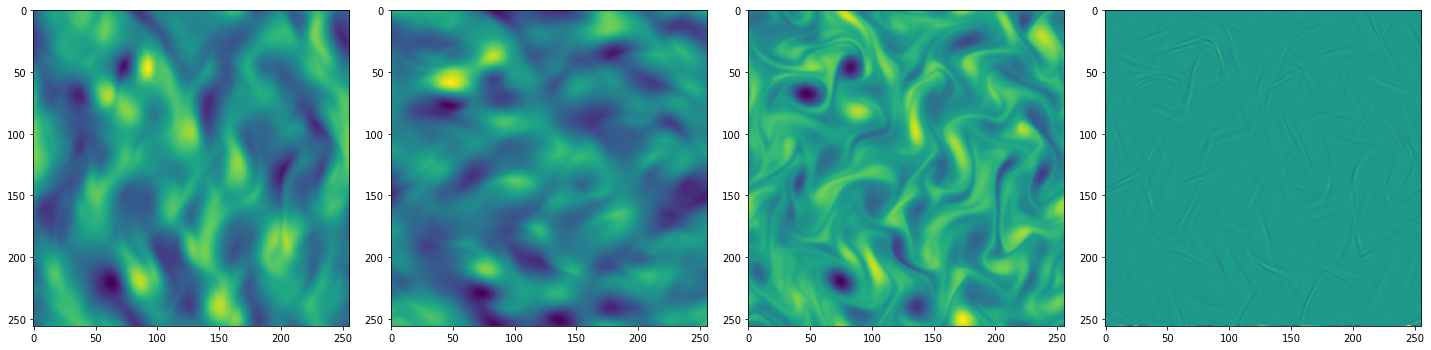

In [5]:
## SET UP DATA
path_to_data = '../data/2021-Turb2D_velocities.npy'
IMGs = np.load(path_to_data)
img_index = 42
X = IMGs[img_index,:,:,:2] / 255
U = IMGs[img_index,:,:,2:]
t = np.arange(0,IMGs.shape[0],step=0.01)
Re = 3900

original_size = X.shape[0]
print('Original size', original_size)

# normalize output
y = U.copy()
print('Y shape', y.shape)
print('Y min, max:', np.min(y), np.max(y))
y = y / np.max(np.abs(y))
print('after normalization, Y min, max:', np.min(y), np.max(y))

ytest = y.copy()
Xtest = X.copy()

W = phy.compute_vorticity(U[:,:,0],U[:,:,1])
D = phy.compute_divergence(U[:,:,0],U[:,:,1])

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(U[:,:,0])
plt.subplot(142)
plt.imshow(U[:,:,1])
plt.subplot(143)
plt.imshow(W)
plt.subplot(144)
plt.imshow(D)
plt.tight_layout()
plt.show()

Xtrain shape: (64, 64, 2)
ytrain shape: (64, 64, 2)


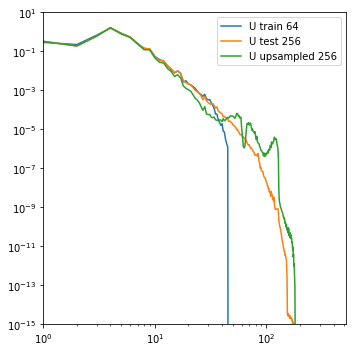

In [6]:
# downsampled resultion
scale = 1/4
coords = np.linspace(0, 1, int(original_size * scale), endpoint=False)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
Xtrain = coords
print('Xtrain shape:', Xtrain.shape)

y1ds = dsp.interpolate2D(X, y[:,:,0], scale=scale)[:,:,None]
y2ds = dsp.interpolate2D(X, y[:,:,1], scale=scale)[:,:,None]
ytrain = np.concatenate([y1ds, y2ds], axis=-1)
print('ytrain shape:', ytrain.shape)

# upsampled resolution
yup = dsp.interpolate2D(Xtrain, ytrain[:,:,0], scale=4)[:,:,None]

# b1, b0, _r, _p_val, _stderr = stats.linregress(np.log10(mx), np.log10(my)) 

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(ytrain[:,:,0]))), phy.powerspec(ytrain[:,:,0]), label='U train 64')
axs.loglog(np.arange(len(phy.powerspec(ytest[:,:,0]))), phy.powerspec(ytest[:,:,0]), label='U test 256')
axs.loglog(np.arange(len(phy.powerspec(yup[:,:,0]))), phy.powerspec(yup[:,:,0]), label='U upsampled 256')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.tight_layout()
plt.show()

# Dataset

In [79]:
class MyDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X, y):

        assert np.max(np.abs(y)) <= 1
        assert np.max(np.abs(X)) <= 1

        'Initialization'
        print('X shape', X.shape)
        print('y shape', y.shape)
        try:
            assert X.shape[0] == y.shape[0]
            assert X.shape[1] == y.shape[1]
        except:
            print('*** Dimension error ***')
            print('X', X.shape)
            print('y', y.shape)
            
        H, W, Cin = X.shape
        H, W, Cout = y.shape
        
        # reshape s.t. B = H*W of query points
        X = X.reshape(H*W, Cin)
        y = y.reshape(H*W, Cout)
        
        self.size = H*W
        # convert to torch and add an empty dimension for the batch
        self.inputs = torch.from_numpy(X).float() #XY x 2 (x,y)
        self.target = torch.from_numpy(y).float()  #XxYx3 (RGB)
        
        assert self.inputs.shape[0] == self.target.shape[0]
        assert self.inputs.shape[1] == self.target.shape[1]
        
        print(self.inputs.shape)
        print(self.inputs.shape)

    def __len__(self):
        'Denotes the total number of samples'
        return self.size

    def __getitem__(self, idx):
        'Generates one sample of data'
        # Load data and get label
        X = self.inputs[idx,...]
        y = self.target[idx,...]

        return X, y


class DataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, 
                 batch_size=2000, num_workers=8):
        
        super().__init__()
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        
    def prepare_data(self):
        self.train_dataset = MyDataset(self.train_data[0], self.train_data[1])
        self.val_dataset = MyDataset(self.val_data[0], self.val_data[1])
        self.test_dataset = MyDataset(self.test_data[0], self.test_data[1])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          self.batch_size, num_workers = self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          self.batch_size, num_workers = self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          self.batch_size, num_workers = self.num_workers)

In [80]:
low_scale = 1/2
Xlow = np.concatenate([
            dsp.interpolate2D(X, Xtest[:,:,0], scale=low_scale)[:,:,None],
            dsp.interpolate2D(X, Xtest[:,:,1], scale=low_scale)[:,:,None]], 
       axis=-1)
ylow = np.concatenate([
            dsp.interpolate2D(X, ytest[:,:,0], scale=low_scale)[:,:,None],
            dsp.interpolate2D(X, ytest[:,:,1], scale=low_scale)[:,:,None]],
        axis=-1)

dm = DataModule(
    train_data=[Xlow, ylow],
    val_data=[Xlow, ylow],
    test_data=[Xlow, ylow],
    batch_size = 128**2,
)

## test
dm.prepare_data()
print('Train')
for batch in dm.train_dataloader():
    x, y = batch
    print(x.shape, y.shape)
    
print('Validation')
for batch in dm.val_dataloader():
    x, y = batch
    print(x.shape, y.shape)

X shape (128, 128, 2)
y shape (128, 128, 2)
torch.Size([16384, 2])
torch.Size([16384, 2])
X shape (128, 128, 2)
y shape (128, 128, 2)
torch.Size([16384, 2])
torch.Size([16384, 2])
X shape (128, 128, 2)
y shape (128, 128, 2)
torch.Size([16384, 2])
torch.Size([16384, 2])
Train
torch.Size([16384, 2]) torch.Size([16384, 2])
Validation
torch.Size([16384, 2]) torch.Size([16384, 2])


# Model

## RFF on batch

In [81]:
class Fourier(nn.Module):
    
    def __init__(self, nfeat=256, scale=10):
        super(Fourier, self).__init__()
        self.b = torch.randn(2, nfeat)*scale
        self.pi = 3.14159265359

    def forward(self, x):
        x = torch.einsum('bc,cf->bf', 2*self.pi*x, self.b.to(x.device))
        return torch.cat([torch.sin(x), torch.cos(x)], -1)

def LinearReLU(n_in, n_out):
    # do not work with ModuleList here either.
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU()
    )
    return block

    
class MLP(nn.Module):
    
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        layers = []
        num_layers = len(dim_layers)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(LinearReLU(dim_layers[l], dim_layers[l+1]))
            
        blocks.append(nn.Linear(dim_layers[-2], dim_layers[-1]))
        blocks.append(nn.Tanh())
        self.network = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.network(x)

    
class RFFNet_pl(pl.LightningModule):
    
    def __init__(self, dim_mpl_layers, f_nfeatures, f_scale, lam_pde=1e-4):
        super(RFFNet_pl, self).__init__()
        
        # regression/pinn network
        self.rff = Fourier(f_nfeatures, f_scale)
        self.mlp = MLP(dim_mpl_layers)
        
        # PINN losses
        self.lam_pde = lam_pde
    
    def forward(self, x): # x := BxC(Batch, InputChannels)

        ## Fourier features
        x = self.rff(x) # Batch x Fourier Features
        ## MLP
        x = self.mlp(x)
        return x

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, x_true = batch
        x_pred = self.forward(x)
        # reconstruction loss
        loss_rec = F.mse_loss(x_pred, x_true)
        # losses 
        loss = loss_rec
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        self.log('train_loss_data', loss_rec)
        return loss

    def validation_step(self, batch, batch_idx):
        x, x_true = batch
        x_pred = self.forward(x)
        loss = F.mse_loss(x_pred, x_true)
        self.log('valid_loss', loss, on_step=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    
# test network
n_features = 256
dim_mlp_layers = [2*n_features] + 3*[256] + [2]
scale = 10
coord_mesh = Xtrain
model = RFFNet_pl(dim_mlp_layers, n_features, scale, device)

print(model)

early_stop_callback = EarlyStopping(monitor='valid_loss')

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=20, 
                     max_epochs=int(10e3), 
                     callbacks=[early_stop_callback])

trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RFFNet_pl(
  (rff): Fourier()
  (mlp): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=256, out_features=2, bias=True)
      (4): Tanh()
    )
  )
)



  | Name | Type    | Params
---------------------------------
0 | rff  | Fourier | 0     
1 | mlp  | MLP     | 263 K 
---------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

(16384, 2)


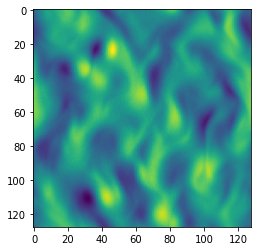

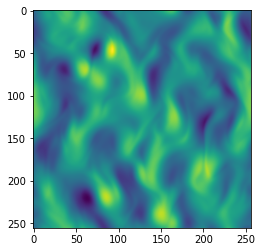

In [29]:
ngrid = 128
model.eval().to(device)
coords = np.linspace(0, 1, ngrid, endpoint=False)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
tmp = coords[:,:,0].copy()
coords[:,:,0] = coords[:,:,1]
coords[:,:,1] = tmp
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)
side = torch.from_numpy(ylow).float().contiguous().to(device)

pred = model(x)
ypred = pred.cpu().detach().numpy().squeeze()

plt.imshow(ypred.reshape(ngrid,ngrid,2)[:,:,0])
plt.show()

plt.imshow(ytest[:,:,0])
plt.show()

# Structure Functions

Warning *** CHECK THE GRADIENT DIRECTION


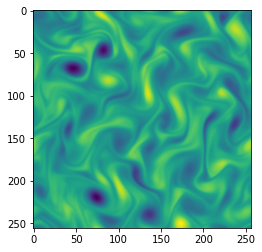

In [153]:
L = np.arange(0,64)

w = phy.compute_vorticity(ytest[:,:,0],ytest[:,:,1])

plt.imshow(w)
plt.show()

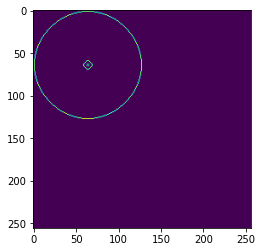

In [9]:
res = ytest.shape[0]
x = np.zeros_like(ytest[:,:,0])

"""
https://en.wikipedia.org/wiki/Midpoint_circle_algorithm
https://github.com/Azrood/python-bresenham/blob/master/bres_cercle.py
"""

def get_cirle_index(xc, yc, x, y):
    return [[xc+x, yc+y],
            [xc-x, yc+y],
            [xc+x, yc-y],
            [xc-x, yc-y],
            [xc+y, yc+x],
            [xc-y, yc+x],
            [xc+y, yc-x],
            [xc-y, yc-x]]

def circleBres(xc,yc,r)  :

    x, y = 0, r
    d = 3 - 2 * r

    indeces = []
    indeces += get_cirle_index(xc, yc, x, y)
    while (y >= x):
        # for each pixel we will draw all eight pixels
        x+=1
        #  check for decision parameter and correspondingly
        #  update d, x, y
        if (d > 0):
            y-=1
            d = d + 4 * (x - y) + 10

        else:
            d = d + 4 * x + 6
        indeces += get_cirle_index(xc, yc, x, y)
                
    return indeces


indeces_list = circleBres(64, 64, 0)
for [i,j] in indeces_list:
    x[i,j] = 1
indeces_list = circleBres(64, 64, 5)
for [i,j] in indeces_list:
    x[i,j] = 1
indeces_list = circleBres(64, 64, 63)
for [i,j] in indeces_list:
    x[i,j] = 1

plt.imshow(x)
plt.show()

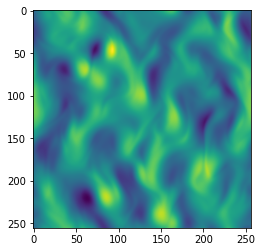

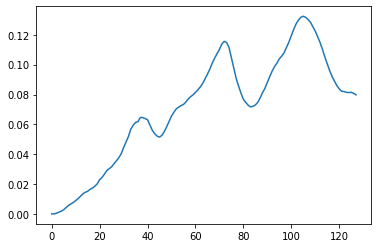

In [65]:
x = ytest[:,:,0]

plt.imshow(x)
plt.show()

L = x.shape[0]//2

S = np.zeros(L)
ptx_x, ptx_y = x.shape[0]//2, x.shape[1]//2

for l in range(L):
    points_in_circle = circleBres(ptx_x, ptx_y, l)
    fun = np.zeros(len(points_in_circle))
    
    img = np.zeros_like(x)
    
    for n, [i,j] in enumerate(points_in_circle):
        fun[n] = (x[i,j] - x[ptx_x, ptx_y])**2
        img[i,j] = 1
        
    S[l] = np.mean(fun)
    
    
plt.plot(S)
plt.show()

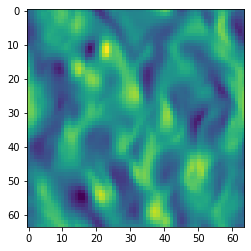

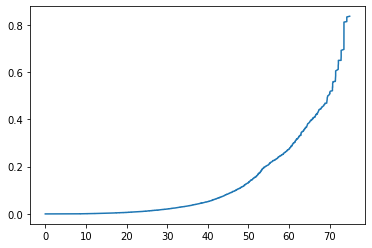

In [27]:
x = ytrain[:,:,0]
H, W = x.shape
    
plt.imshow(x)
plt.show()

ptx = [10, 10]

S = np.zeros((H*W,2))
c = 0
for i in range(H):
    for j in range(W):
        if i == ptx[0] and j == ptx[1]:
            S[c,0] = 0
            S[c,1] = 0
        else:
            S[c,0] = np.sqrt((i-ptx[0])**2 + (j-ptx[1])**2)
            S[c,1] = (x[i,j] - x[ptx[0],ptx[1]])**2
        c += 1

S = np.sort(S, axis=0)

plt.plot(S[:,0],S[:,1])
plt.show()

Done


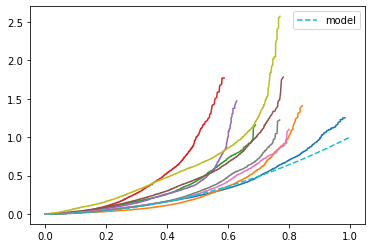

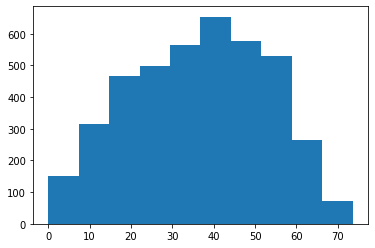

In [119]:
x = ytest[::4,::4,:]
H, W, D = x.shape


coords2D = np.zeros((H*W,2), dtype=int)
c = 0
for i in range(H):
    for j in range(W):
        coords2D[c,0] = i
        coords2D[c,1] = j
        c += 1

c = 0
S = np.zeros((H*W,H*W,2))
for c in range(coords2D.shape[0]):
    ptx = coords2D[c,:]
    dist = np.sqrt(np.sum((coords2D-ptx[None,:])**2, axis=1))
    S[c,:,0] = dist
    
    sfun = np.linalg.norm(x - x[ptx[0],ptx[1],:], axis=-1)**2
    S[c,:,1] = sfun.flatten()
    c += 1
print('Done')


for c in range(0,H*W,500):
    currS = np.sort(S[c,:,:],axis=0)
    plt.plot(currS[:,0]/(64*1.4141),currS[:,1])

#model
sup = np.linspace(0,1,100)
plt.plot(sup, 1*sup**2, '--', label='model')
plt.legend()
plt.show()

plt.hist(S[300,:,0])
plt.show()

# cc = 0
# for ii in range(H):
#     for jj in range(W):
#         ptx = [ii, jj]

#         S = np.zeros((H*W,2))
#         c = 0
        
#         for i in range(H):
#             for j in range(W):
#                 if i == ptx[0] and j == ptx[1]:
#                     SS[cc,c,0] = 0
#                     SS[cc,c,1] = 0
#                 else:
#                     SS[cc,c,0] = np.sqrt((i-ptx[0])**2 + (j-ptx[1])**2)
#                     SS[cc,c,1] = (x[i,j] - x[ptx[0],ptx[1]])**2
#                 c += 1
#         cc += 0

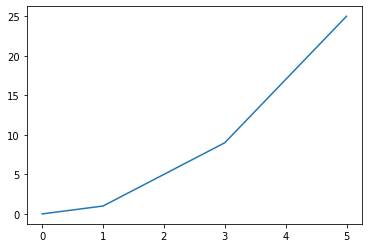

In [103]:
a = np.array([0,1,1,1,1,1,3,5,5,5])
plt.plot(a,a**2)
plt.show()

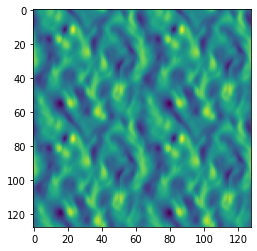

In [15]:
x = ytest[::4,::4,:]

# the data are periodic, so we can concatenate the same column
x = np.concatenate([x, x], axis=1)
x = np.concatenate([x, x], axis=0)
plt.imshow(x[:,:,0])
plt.show()

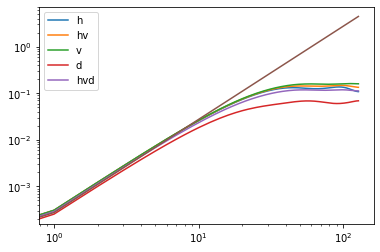

In [73]:
# Structure Function
x = ytest[::1,::1,:]
img_shape = x.shape[0]
L = img_shape//2

Sh = np.zeros(L)
Sv = np.zeros_like(Sh)
Sd = np.zeros_like(Sh)

x_padded = np.concatenate([x, x], axis=1)
# horizontal
for l in range(L):
    v = x
    vl = x_padded[:,l:l+img_shape,:]
    Sh[l] = np.mean((vl[:,:,1]-v[:,:,1])**2, axis=(0,1))

# vertical
x_padded = np.concatenate([x, x], axis=0)
for l in range(L):
    v = x
    vl = x_padded[l:l+img_shape,:,:]
    Sv[l] = np.mean((vl[:,:,0]-v[:,:,0])**2, axis=(0,1))
    
# diagonal
x_padded = np.concatenate([x,x], axis=0)
x_padded = np.concatenate([x_padded,x_padded], axis=1)

for l in range(L):
    v = x
    vl = x_padded[l:l+img_shape,l:l+img_shape,:]
    Sd[l] = np.mean((0.5*(vl[:,:,0]-v[:,:,0])+0.5*(vl[:,:,1]-v[:,:,1]))**2, axis=(0,1))
    
plt.loglog(Sh, label='h')
plt.loglog(0.5*Sh+0.5*Sv, label='hv')
plt.loglog(Sv, label='v')
plt.loglog(Sd, label='d')
plt.loglog((Sd+Sv+Sh)/3, label='hvd')
plt.loglog(np.arange(L), 0.000275*np.arange(L)**2)
plt.legend()
plt.show()

ValueError: XA must be a 2-dimensional array.